# Baseline model: Africa data
- Import excel file, add date column and export it as json. Use json file for analysis
- Data formatting: column names 
- Filter data since 2010
- Function to plot specific country
- Encode event_type and sub_event_type
- Aggregate by month. Working dataset for ML

In [1]:
# African dataset
# https://www.acleddata.com/curated-data-files/

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Exporting excel file as json

In [4]:
# # import excel file
# df = pd.read_excel('../data/Africa_1997-2019_Oct12-1.xlsx')

In [5]:
# # New column for date & month
# df['date'] = pd.to_datetime(df['EVENT_DATE']).dt.date

In [6]:
# # export dataframe as json
# df.to_json('../data/africa-data.json')

## Importing data

In [7]:
df = pd.read_json('../data/africa-data.json')

In [8]:
df.shape

(193565, 30)

In [9]:
# df.head()

## Data formatting
- Rename columns
- Encode values
- Define classification according to event/fatalities?

In [10]:
# Rename and remove columns
columns = ['YEAR', 'EVENT_TYPE', 'SUB_EVENT_TYPE', 'ACTOR1', 'REGION', 'COUNTRY', 'SOURCE', 'FATALITIES', 'date']
try:
    df = df[columns]
    df.columns = ['year', 'event_type', 'sub_event_type', 'actor', 'region', 'country', 'source', 'fatalities', 'date']
except KeyError as e:
    print(e)
    pass

print(df.columns)
print(df.shape)

Index(['year', 'event_type', 'sub_event_type', 'actor', 'region', 'country', 'source', 'fatalities', 'date'], dtype='object')
(193565, 9)


In [11]:
# Encode event_types and sub_event_types
# https://www.datacamp.com/community/tutorials/categorical-data

In [12]:
# print('**Categorical values**\n')
# print('{} event types:\n {}\n'.format(df.event_type.nunique(), df.event_type.unique()))
# print('{} sub_event types:\n {}\n'.format(df.sub_event_type.nunique(), df.sub_event_type.unique()))
# print('{} actors:\n {}\n'.format(df.actor.nunique(), df.actor.unique()))
# print('{} countries:\n {}\n'.format(df.country.nunique(), df.country.unique()))

## Plot data for a specific country
- Filter data since 2010
- Resample data by year
- Pivot table to plot all data
- Function> Filter data by specific country, aggregate by year. Plot

In [13]:
# Include data since 2010
filtered_data = df[df.year > 2009]
filtered_data['year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [14]:
# Group by data by date, resample by year, set date as index
all_data = filtered_data.groupby(['date'])['event_type'].count()
all_data_year = all_data.resample('Y').sum()
all_data_year.index = pd.to_datetime(all_data_year.index)

In [15]:
all_data_year.index

DatetimeIndex(['2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31'], dtype='datetime64[ns]', name='date', freq='A-DEC')

In [21]:
# Pivot table to display all data by country, year, event count

all_countries = filtered_data.groupby(['year', 'country'])['event_type'].count().\
                reset_index(level=['year','country'])

all_countries = pd.pivot_table(all_countries, index= 'year', columns='country', values = 'event_type')


# Graph
# plt.rcParams['figure.figsize'] = (20, 10)
# all_countries.plot(subplots = False, style='-', alpha=0.3, color = 'gray')
# plt.legend().remove()

In [22]:
# print(worst_country.loc[worst_country['event_type'].idxmax()])
# # print('\n')
# # print(worst_country.loc[worst_country['event_type'].min()])
# print(worst_country.loc[worst_country['event_type'].max(level = 'year')])

In [47]:
#Function to get data for one specific country.
# Plot data in a timeline. 

def country_data(data, name_country = ""):
    global df_country
    try:
        #Query and group data by specified country
        df_country = data.query('country == "{}"'.format(name_country))      
        fatalities = df_country.groupby(['date'])['fatalities'].sum()  
        event_type = df_country.groupby(['date'])['event_type'].count()
                
        #matplotlib graph: All cases over time, rolling for country & total
        plt.rcParams['figure.figsize'] = (20, 12)        
        all_countries.plot(subplots=False, style='-', alpha=0.2, color = 'gray')
        all_countries[name_country].plot(subplots=False, style='--', linewidth = 2, alpha=1, color = 'r')
        plt.legend().remove()
        
        print('\n(Data from {} countries)'.format(all_countries.index.nunique()))

        plt.title('{} of events in {} ({} fatalities) (2010 - 2019)\n'.\
              format(df_country['event_type'].count(), name_country, df_country.fatalities.sum()))
        
        plt.xlabel('Tears')
        plt.ylabel('Fatalities')

              
    except (NameError, KeyError) as e:
        print('Error: {}'.format(e))
        plt.legend().remove()
        pass



(Data from 10 countries)


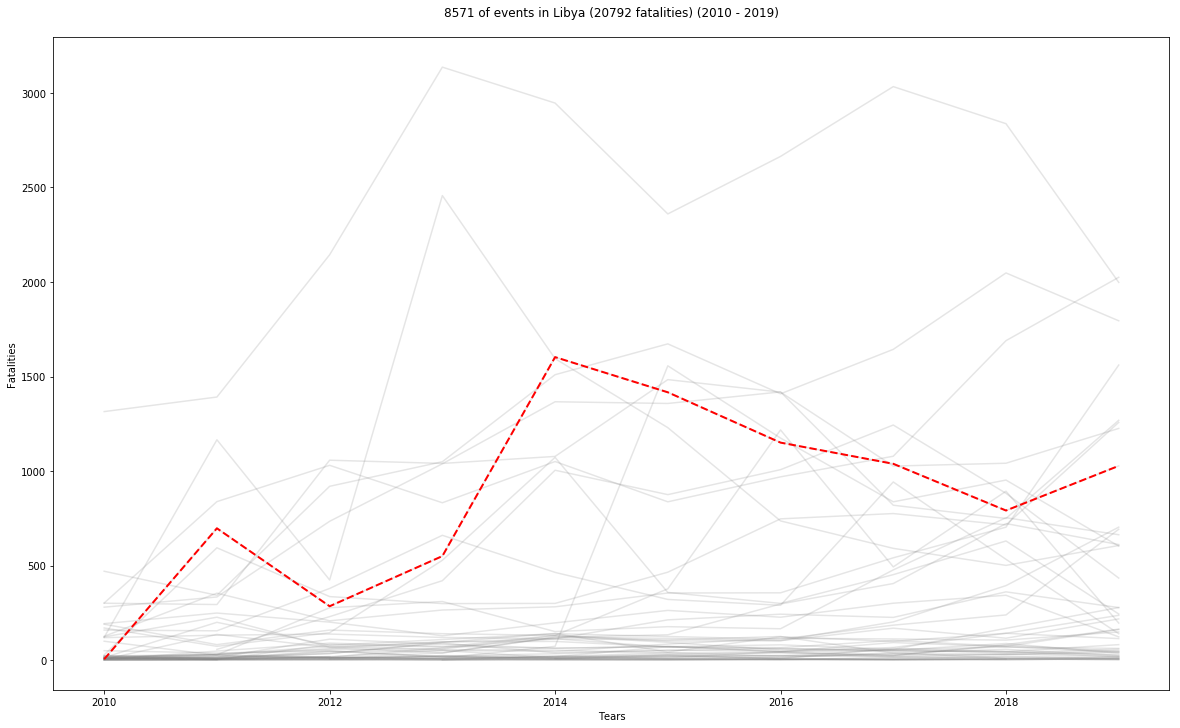

In [48]:
country_data(filtered_data, 'Libya')

# ML models
- K-clustering for all countries

## Encoding data for all countries since 2010

In [49]:
# Encoding labels
# Selecting labels for encoding in baseline model
labels = ['event_type','sub_event_type', 'country']
labels = df[labels]
labels.head()

,event_type,sub_event_type,country
0,Violence against civilians,Attack,Algeria
1,Violence against civilians,Attack,Algeria
10,Explosions/Remote violence,Remote explosive/landmine/IED,Algeria
100,Explosions/Remote violence,Remote explosive/landmine/IED,Algeria
1000,Violence against civilians,Abduction/forced disappearance,Algeria


In [50]:
# Adding a boolean column for fatalities
df['fatalities_encoded'] = np.where(df['fatalities']>0, '1', '0')

In [51]:
# One-Hot Encoding with get_dummies
labels_encoded = pd.get_dummies(labels)

In [52]:
labels_encoded.head()

,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Strategic developments,event_type_Violence against civilians,sub_event_type_Abduction/forced disappearance,sub_event_type_Agreement,sub_event_type_Air/drone strike,sub_event_type_Armed clash,sub_event_type_Arrests,sub_event_type_Attack,sub_event_type_Change to group/activity,sub_event_type_Chemical weapon,sub_event_type_Disrupted weapons use,sub_event_type_Excessive force against protesters,sub_event_type_Government regains territory,sub_event_type_Grenade,sub_event_type_Headquarters or base established,sub_event_type_Looting/property destruction,sub_event_type_Mob violence,sub_event_type_Non-state actor overtakes territory,sub_event_type_Non-violent transfer of territory,sub_event_type_Other,sub_event_type_Peaceful protest,sub_event_type_Protest with intervention,sub_event_type_Remote explosive/landmine/IED,sub_event_type_Sexual violence,sub_event_type_Shelling/artillery/missile attack,sub_event_type_Suicide bomb,sub_event_type_Violent demonstration,country_Algeria,country_Angola,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Central African Republic,country_Chad,country_Democratic Republic of Congo,country_Djibouti,country_Egypt,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Libya,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Morocco,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Republic of Congo,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Sudan,country_Tanzania,country_Togo,country_Tunisia,country_Uganda,country_Zambia,country_Zimbabwe,country_eSwatini
0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1000,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [107]:
# Dataset with labels + encoded columns
all_labels = pd.concat([labels, labels_encoded], axis=1, sort=False)
# all_labels.iloc[2]

In [54]:
# df = pd.concat([df, labels_encoded], axis = 1, sort = False)
# df.iloc[1]

## K-clustering all countries
- https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46

In [55]:
#Check if the are any null values in data
df.isnull().values.any()
# print(df.isnull().sum())

False

In [56]:
# Use k-clustering to detect anomalies
from sklearn.cluster import KMeans

In [57]:
# Select X values 
n = len(filtered_data.columns)
X = filtered_data.iloc[:,np.r_[0,7,9:n]]
# X.iloc[0]

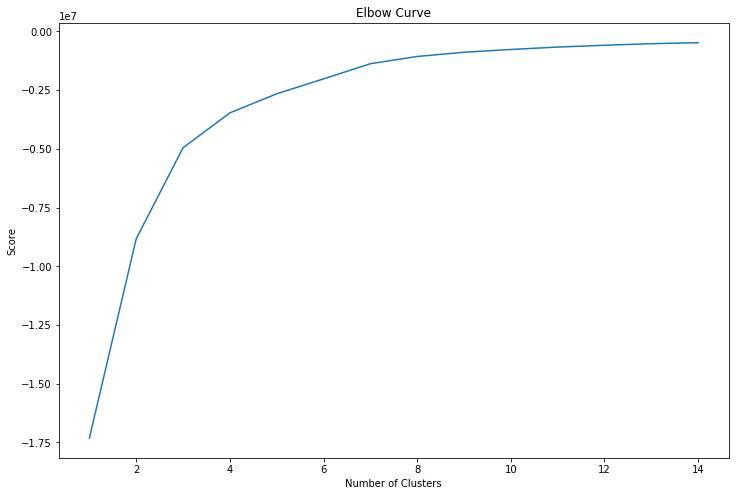

In [58]:
# Use elbow method to select number of clusters

n_cluster = range(1, 15)
kmeans = [KMeans(n_clusters=i).fit(X) for i in n_cluster]
scores = [kmeans[i].score(X) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [59]:
# K-clustering
c = 10
clusters = KMeans(n_clusters=c)
clusters.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [60]:
X['labels'] = clusters.predict(X)

/Users/cmserna/Sites/virtualenvs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [129]:
filtered_data['labels'] = X.labels

/Users/cmserna/Sites/virtualenvs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [130]:
filtered_data.labels.value_counts()

6    51880
0    45535
7    33323
9     9094
3     2451
2      744
4      225
8       59
1       30
5       13
Name: labels, dtype: int64

In [137]:
filtered_data[filtered_data.labels == 5]

,year,event_type,sub_event_type,actor,region,country,source,fatalities,date,labels
125875,2017,Explosions/Remote violence,Remote explosive/landmine/IED,Al Shabaab,Eastern Africa,Somalia,AFP,587,2017-10-14,5
148936,2011,Violence against civilians,Attack,Murle Ethnic Militia (Sudan),Eastern Africa,South Sudan,Small Arms Survey,750,2011-08-18,5
148938,2011,Violence against civilians,Attack,Murle Ethnic Militia (South Sudan),Eastern Africa,South Sudan,Small Arms Survey,750,2011-08-18,5
148990,2012,Violence against civilians,Attack,Lou Nuer Ethnic Militia (South Sudan),Eastern Africa,South Sudan,Sudan Tribune; Small Arms Survey; Al Arabiya,597,2012-01-01,5
148994,2012,Violence against civilians,Attack,Lou Nuer Ethnic Militia (South Sudan),Eastern Africa,South Sudan,Al Arabiya; Sudan Tribune; Small Arms Survey,597,2012-01-02,5
148995,2012,Violence against civilians,Attack,Lou Nuer Ethnic Militia (South Sudan),Eastern Africa,South Sudan,Al Arabiya; Sudan Tribune; Small Arms Survey,597,2012-01-03,5
148996,2012,Violence against civilians,Attack,Lou Nuer Ethnic Militia (South Sudan),Eastern Africa,South Sudan,Al Arabiya; Small Arms Survey; Sudan Tribune,597,2012-01-04,5
148997,2012,Violence against civilians,Attack,Lou Nuer Ethnic Militia (South Sudan),Eastern Africa,South Sudan,Sudan Tribune; Small Arms Survey; Al Arabiya,598,2012-01-05,5
159249,2011,Violence against civilians,Attack,Military Forces of Sudan (1989-),Northern Africa,Sudan,Africa Confidential; Canadian Press,500,2011-06-05,5
61303,2011,Explosions/Remote violence,Remote explosive/landmine/IED,Operation Unified Protector: NATO Mission in L...,Northern Africa,Libya,Reuters,718,2011-05-31,5


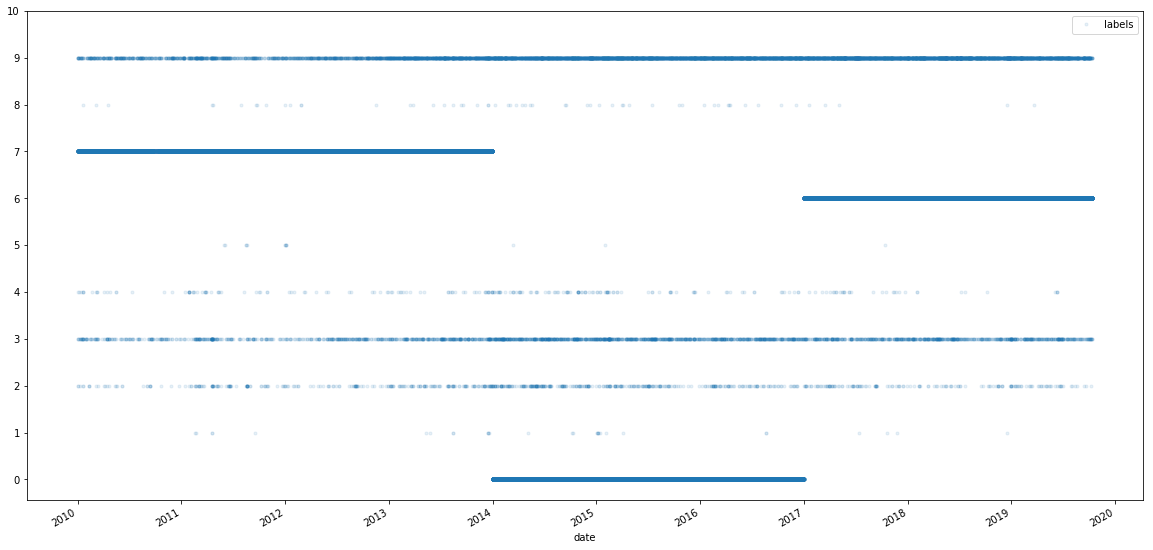

In [116]:
filtered_data.plot(x = 'date', y='labels', figsize=(20, 10), style='.', alpha=0.1)
plt.yticks(np.arange(min(filtered_data.labels), max(filtered_data.labels)+2, 1.0))
plt.show()

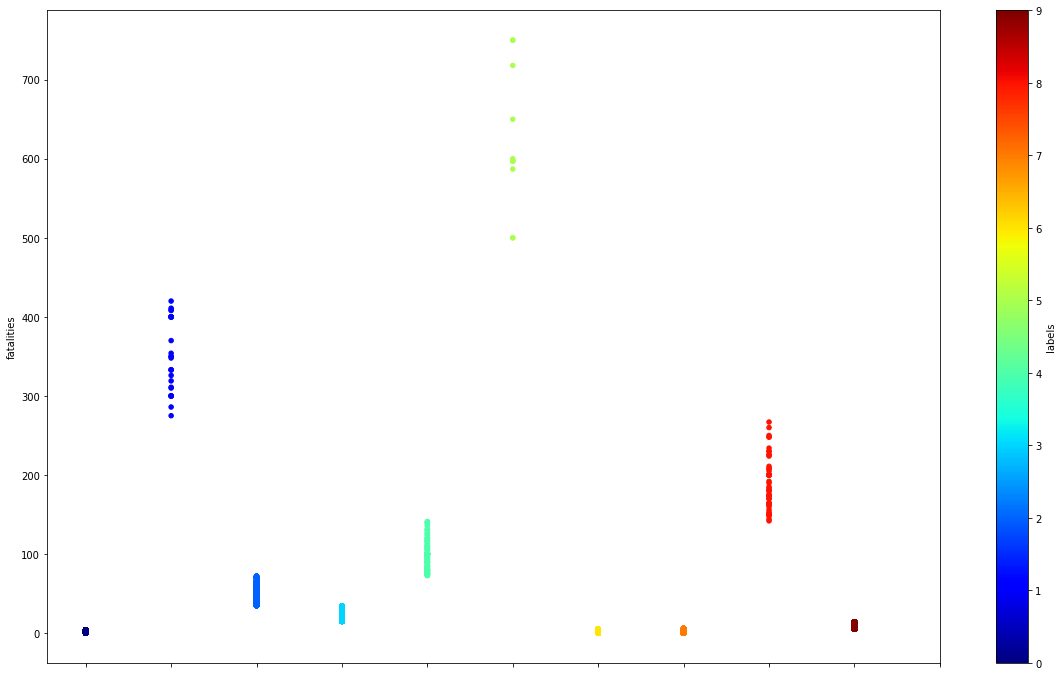

In [119]:
X.plot.scatter('labels', 'fatalities', c='labels', colormap='jet')
plt.xticks(np.arange(min(X.labels), max(X.labels)+2, 1.0))
plt.show()

In [ ]:
# Use PCA to determine most significatn columns

## Using Random Forest

In [ ]:
# https://www.kaggle.com/adithya44/anomaly-detection-isolation-forest-visualization